In [ ]:
import os
from functools import reduce
from typing import List
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from Model.ModelEarly2D import ModelEarly2D, ModeTestChannel
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

read config params

In [ ]:
f = open("config.txt")
configParams = f.readlines()
f.close()
configParams = eval("\n".join(configParams))

multiplierCoord = configParams["multiplierCoord"]
thresholdCuDi = configParams["thresholdCuDi"]# value in pixel
dimensionsImage,canal = np.array(configParams["dimensionsOutputImage"]),2 # x and
actionFileName = "Actions.csv"

In [ ]:
nbClass=31
pathModelGeneral,separator = "C:\\workspace2\\Datasets\\2D\\MTG\\MTGSetB\\Log\\splendid-bush-10930\\","\\"
pathModel = pathModelGeneral+"Weights\\model"
pathPreprocessedData = "C:\\workspace2\\Datasets\\2D\\MTG\\MTGSetB\\PreprocessedData\\"

dilatationRates = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
config = {    "multiplierCoord":multiplierCoord,
              "treshCudi":thresholdCuDi,
                "dimension":[dimensionsImage[0],dimensionsImage[1]],
               "batchSize": 40,
               "lambdahyper": 32,
                "couverture":0.75,
              "weightLoss1":0.5,
              "learning_rate":0.003,
               "doGlu":False,
               "dropoutVal":0.1,
               "denseSize":150,
               "denseDropout":0.3,
               "nbFeatureMap":25,
               "dilatationRates":dilatationRates,
               "maxPoolSpatial":True,
               "poolSize":(1,3,3),
                "nbDenseLayer":1,
              "modeChannel":ModeTestChannel.BOTH
               }

### Prepare the test data

In [ ]:
testFiles = os.listdir(pathPreprocessedData+"Test")
nbTest = len(testFiles)

def generatorData(pathPrepro:str, filesList: List[str]):
    for file in filesList:
        data = np.load(pathPrepro + separator + file)
        # data = tf.cast(data,tf.float32)
        label = [int(file.split("_")[1].split(".")[0])]*len(data) # we repeat the label
        yield data, tf.expand_dims(label,axis=-1)
generatorDataTest = lambda  : generatorData(pathPrepro=pathPreprocessedData+"Test",filesList=testFiles)

def repeatGT(input1, input2):
    #input 2 : [batch seq 1]
    # input2 = tf.reshape(input2,[tf.shape(input2)[0],tf.shape(input2)[1]])
    # input2 = tf.one_hot(tf.cast(input2,tf.int32),nbClass) #[batch,segments,nbClass]
    return input1,(input2,input2)
def getDataset(generator):
    output_shapes = (tf.TensorShape([None, dimensionsImage[0], dimensionsImage[1], canal]),
                                       tf.TensorShape([None, 1]))
    dataset = tf.data.Dataset.from_generator(
                        generator,
                        output_types=(tf.float32, tf.float32),
                        output_shapes=output_shapes
                    )
    toPad = ((tf.constant(0.)), tf.constant(0.))
    dataset = dataset.padded_batch(1, padded_shapes=output_shapes,
                                           padding_values=toPad)

    dataset = dataset.map(repeatGT) # repeat the GT
    return dataset
datasetTest = getDataset(generatorDataTest)

In [ ]:
catCroEnt = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

def lossFGWithReject(y_true,y_pred,lambdaHyper):
    #y_true: [batch,nbSeg,nbClass]
    #y_pred: [batch,nbSeg,nbClass]
    loss = catCroEnt(
        tf.repeat(y_pred[:,:,:1],nbClass,axis=2) * y_true, # g(x)*ytrue * log(pred)
        y_pred[:,:,1:])
    loss += lambdaHyper*tf.maximum(config["couverture"]-tf.reduce_mean(y_pred[:,:,0]),0)**2
    return loss

def lossHAux(y_true,y_pred):
    loss = catCroEnt(y_true,y_pred)
    return loss
model = ModelEarly2D(nbClass=nbClass,boxSize=(dimensionsImage[0],dimensionsImage[1],canal),
                     doGLU=config["doGlu"],dropoutVal=config["dropoutVal"],denseNeurones=config["denseSize"],
                     denseDropout=config["denseDropout"],nbFeatureMap=config["nbFeatureMap"],
                     dilatationsRates=config["dilatationRates"],maxPoolSpatial=config["maxPoolSpatial"],
                     poolSize=config["poolSize"],poolStrides=config["poolSize"],modeChannel=config["modeChannel"])
opti = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
model.compile(opti, loss=[lambda x,y:lossFGWithReject(x,y,config['lambdahyper']),lossHAux], metrics=[])
model.load_weights(pathModel)

In [ ]:
# model.evaluate(datasetTest)

In [ ]:
eval = model.predict(datasetTest,steps=1)
print(eval[0].shape)

In [ ]:
iterator = iter(datasetTest)

In [ ]:
N = [0]*nbClass
TrueAccept = [0]*nbClass
FalseAccept = [0]*nbClass
TrueAcceptAt = []
FalseAcceptAt = []

TrueAcceptWoReject = [0]*nbClass
FalseAcceptWoReject = [0]*nbClass
averageLengthCompletion = [[] for i in range(nbClass)]

rejected = [0]*nbClass
# FalseReject = 0
# TrueReject = 0
# ScoreByLength = {}

In [ ]:
t = 1 #number of time the accepted prediction must be repeated to be accepted
confMatrix = np.zeros([nbClass, nbClass], dtype=int)

for i,data in enumerate(iterator):
    if(i%100==0):
        print(i,"/",len(testFiles))
    # file = testFiles[i]
    # print(file)
    input = data[0]
    GT = data[1][0][0][0][0].numpy() # the GT is repeted along this axis
    # if(GT>1):
    #     GT-=1
    # elif(GT==1):
    #     GT=31
    orginalLengthWithoutBlack = input.shape[1]-1
    nbBlackImgToAdd = 8
    blacks = tf.zeros([1,nbBlackImgToAdd,40,40,2])
    input = tf.concat([input,blacks],axis=1)

    N[int(GT)]+=1
    treshAccept = 0.5
    prediction = model(input,steps=1,training=False)[0][0] # get prediction output
    # print("prediction",tf.shape(prediction))
    rejection = prediction[:,0]
    rejection = tf.greater(rejection,treshAccept).numpy()
    prediction = prediction[:,1:]
    prediction = tf.argmax(prediction,axis=1).numpy()
    acceptIndex = np.where(rejection>treshAccept)[0]
    if len(acceptIndex)>0 :# or prediction[-1]==0 or prediction[-1]==5:
      # get results if we don't use the rejet, use the result of the last frame
        if prediction[-1]==GT:
            TrueAcceptWoReject[int(GT)]+=1
        else:
            FalseAcceptWoReject[int(GT)]+=1

        firstAcceptIndex = acceptIndex[0]
        repeatedTTime = False
        if t>1: # if we want to repeat the prediction t times to assure this is the good class
            currentClass = prediction[firstAcceptIndex]
            cpt_repeat=0 # 0 because first loop is the currentClass
            while firstAcceptIndex<len(prediction) and not repeatedTTime:
                predi = prediction[firstAcceptIndex]
                if currentClass == predi:
                    cpt_repeat+=1
                    if cpt_repeat>=t:
                        repeatedTTime=True
                        break
                else:
                    currentClass = predi
                    cpt_repeat = 1
                firstAcceptIndex+=1
            if not repeatedTTime: # if the prediction is never repeated t times, it is rejected
                rejected[int(GT)] +=1
                continue # don't do the rest
        pred = prediction[firstAcceptIndex]
        if firstAcceptIndex>orginalLengthWithoutBlack-1:
            firstAcceptIndex = orginalLengthWithoutBlack-1 # if we predict on the black image, it's the same gesture completion of the image just  before
        if pred==GT:
            TrueAccept[int(GT)]+=1
            TrueAcceptAt+=[float(firstAcceptIndex+1)/(float(orginalLengthWithoutBlack))]
        else:
            FalseAccept[int(GT)]+=1
            FalseAcceptAt+=[float(firstAcceptIndex+1)/(float(orginalLengthWithoutBlack))]
        averageLengthCompletion[int(GT)]+=[float(firstAcceptIndex+1)/(float(orginalLengthWithoutBlack))]
        confMatrix[int(GT)][pred]+=1
    else:
        rejected[int(GT)] +=1



In [ ]:
N = np.array(N)
TrueAccept = np.array(TrueAccept)
FalseAccept = np.array(FalseAccept)
rejected = np.array(rejected)
avPerClass = [sum(av)/len(av) if len(av)>0 else 1 for av in averageLengthCompletion]

res = ""
res+="TrueAcceptPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in TrueAccept/N])))+"\n"
res+="FalseAcceptPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in  FalseAccept/N])))+"\n"
res+="rejectedPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in rejected/N])))+"\n"
res+="averageLengthCompletionPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in avPerClass])))+"\n"
N_ = sum(np.array(N))
TrueAccept_ = sum(np.array(TrueAccept))
FalseAccept_ = sum(np.array(FalseAccept))
rejected_ = sum(np.array(rejected))
res+="TrueAccept,\n"+str(TrueAccept_/N_)+"\n"
res+="FalseAccept,\n"+str(FalseAccept_/N_)+"\n"
res+="rejected,\n"+str(rejected_/N_)+"\n"
allAv = reduce(lambda a,b:a+b,averageLengthCompletion)
av = sum(allAv)/len(allAv)
res+="averageLengthCompletion\n"+str(av)+"\n"


print(res)



In [ ]:
f = open(pathModelGeneral+"resultsEval"+("_t"+str(t) if t>1 else "")+".txt","w+")
f.write(res)
f.close()

## scores wihtout reject option, take prediction of last frame

In [ ]:
TrueAcceptWoReject  = np.array(TrueAcceptWoReject)
FalseAcceptWoReject = np.array(FalseAcceptWoReject)
res = ""
res+="GoodPredPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in TrueAcceptWoReject/N])))+"\n"
res+="FalsePredPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in  FalseAcceptWoReject/N])))+"\n"
TrueAcceptWoReject_ = sum(np.array(TrueAcceptWoReject))
FalseAcceptWoReject_ = sum(np.array(FalseAcceptWoReject))
Accuracy = (TrueAcceptWoReject_)/(TrueAcceptWoReject_+FalseAcceptWoReject_)
res+="Accuracy : "+str(Accuracy)+"\n"
res+="Error rate : "+str(1-Accuracy)

print(res)

In [ ]:
f = open(pathModelGeneral+"resultsEvalAccuracyWoReject.txt","w+")
f.write(res)
f.close()

## Exploring per class earliness

In [ ]:
f = open(pathPreprocessedData+actionFileName)
actions  =  f.readlines()
f.close()
actions = list(map(lambda s: s.split(";")[1].strip(),actions))

In [ ]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)


_ = plt.bar(actions, avPerClass)


plt.xlabel('Class label')
plt.ylabel('Earliness')
# plt.title('Histogram representing the earliness of each class')

plt.savefig(pathModelGeneral+"earlinessPerClass"+("_t"+str(t) if t>1 else ""), bbox_inches='tight')
plt.savefig(pathModelGeneral+"earlinessPerClass"+("_t"+str(t) if t>1 else "")+".eps", bbox_inches='tight',format='eps')

## Confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix, display_labels=actions)
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax, values_format="")
plt.savefig(pathModelGeneral + "confusionMatrix"+("_t"+str(t) if t>1 else "")+".png")

In [ ]:
norm_confMatrix = confMatrix / (np.sum(confMatrix, axis=1)[:, np.newaxis])
fig, ax = plt.subplots(figsize=(50,50))
disp = ConfusionMatrixDisplay(confusion_matrix=norm_confMatrix, display_labels=actions)
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax, values_format=".2f")
plt.savefig(pathModelGeneral + "confusionMatrixNorm"+("_t"+str(t) if t>1 else "")+".png")

## Behaviour with reject

In [ ]:
plt.rcParams.update({'font.size': 26})
plt.figure(figsize=(10,5.5),dpi=180)
xAbs = np.linspace(0,1,100)
flat_averageLengthCompletion = [item for sublist in averageLengthCompletion for item in sublist]

lengcomplt = np.array(flat_averageLengthCompletion)
# lengcomplt[]
rejectsAt = np.array(list(map(lambda x : 1-len(lengcomplt[lengcomplt<=x])/N_,xAbs)))
plt.plot(xAbs, rejectsAt,color="blue")


TrueAcceptAt = np.array(TrueAcceptAt)
FalseAcceptAt = np.array(FalseAcceptAt)
totalExemples = len(lengcomplt)

#cumulated TAR and FAR
TARAt = np.array(list(map(lambda x : len(TrueAcceptAt[TrueAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, TARAt,color="green")



FARAt = np.array(list(map(lambda x : len(FalseAcceptAt[FalseAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, FARAt,color="red")
plt.grid(axis="y",linestyle="-",linewidth=.4)

plt.legend(["Reject Rate","Cumulative TAR","Cumulative FAR"])
plt.xlabel("Gesture completion")
plt.ylabel("Rate")

# plt.plot(X, Yb)
# plt.plot(X, Yb)
plt.savefig(pathModelGeneral+"TAR_FAR_Reject"+("_t"+str(t) if t>1 else "")+".eps", bbox_inches='tight',format='eps')
plt.savefig(pathModelGeneral+"TAR_FAR_Reject"+("_t"+str(t) if t>1 else ""), bbox_inches='tight')


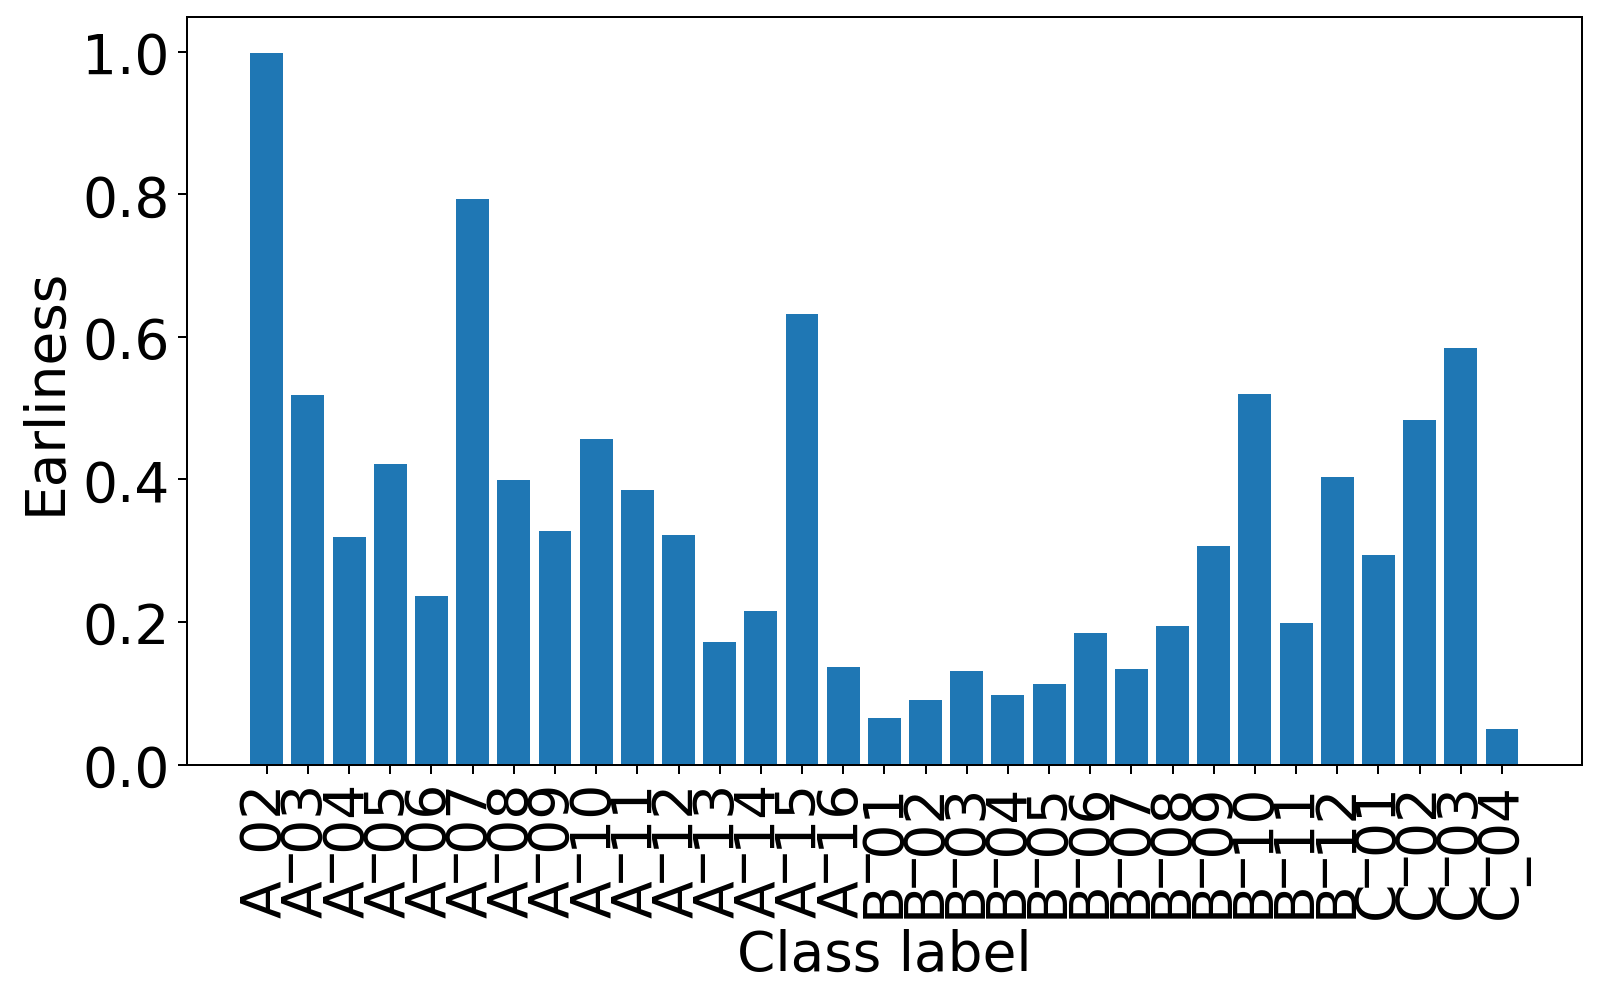

In [16]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)


_ = plt.bar(actions, avPerClass)


plt.xlabel('Class label')
plt.ylabel('Earliness')
# plt.title('Histogram representing the earliness of each class')

plt.savefig(pathModelGeneral+"earlinessPerClass"+("_t"+str(t) if t>1 else ""), bbox_inches='tight')
plt.savefig(pathModelGeneral+"earlinessPerClass"+("_t"+str(t) if t>1 else "")+".eps", bbox_inches='tight',format='eps')

## Confusion matrix

In [17]:
fig, ax = plt.subplots(figsize=(30, 30))
disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix, display_labels=actions)
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax, values_format="")
plt.savefig(pathModelGeneral + "confusionMatrix"+("_t"+str(t) if t>1 else "")+".png")

In [18]:
norm_confMatrix = confMatrix / (np.sum(confMatrix, axis=1)[:, np.newaxis])
fig, ax = plt.subplots(figsize=(50,50))
disp = ConfusionMatrixDisplay(confusion_matrix=norm_confMatrix, display_labels=actions)
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax, values_format=".2f")
plt.savefig(pathModelGeneral + "confusionMatrixNorm"+("_t"+str(t) if t>1 else "")+".png")

## Behaviour with reject

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


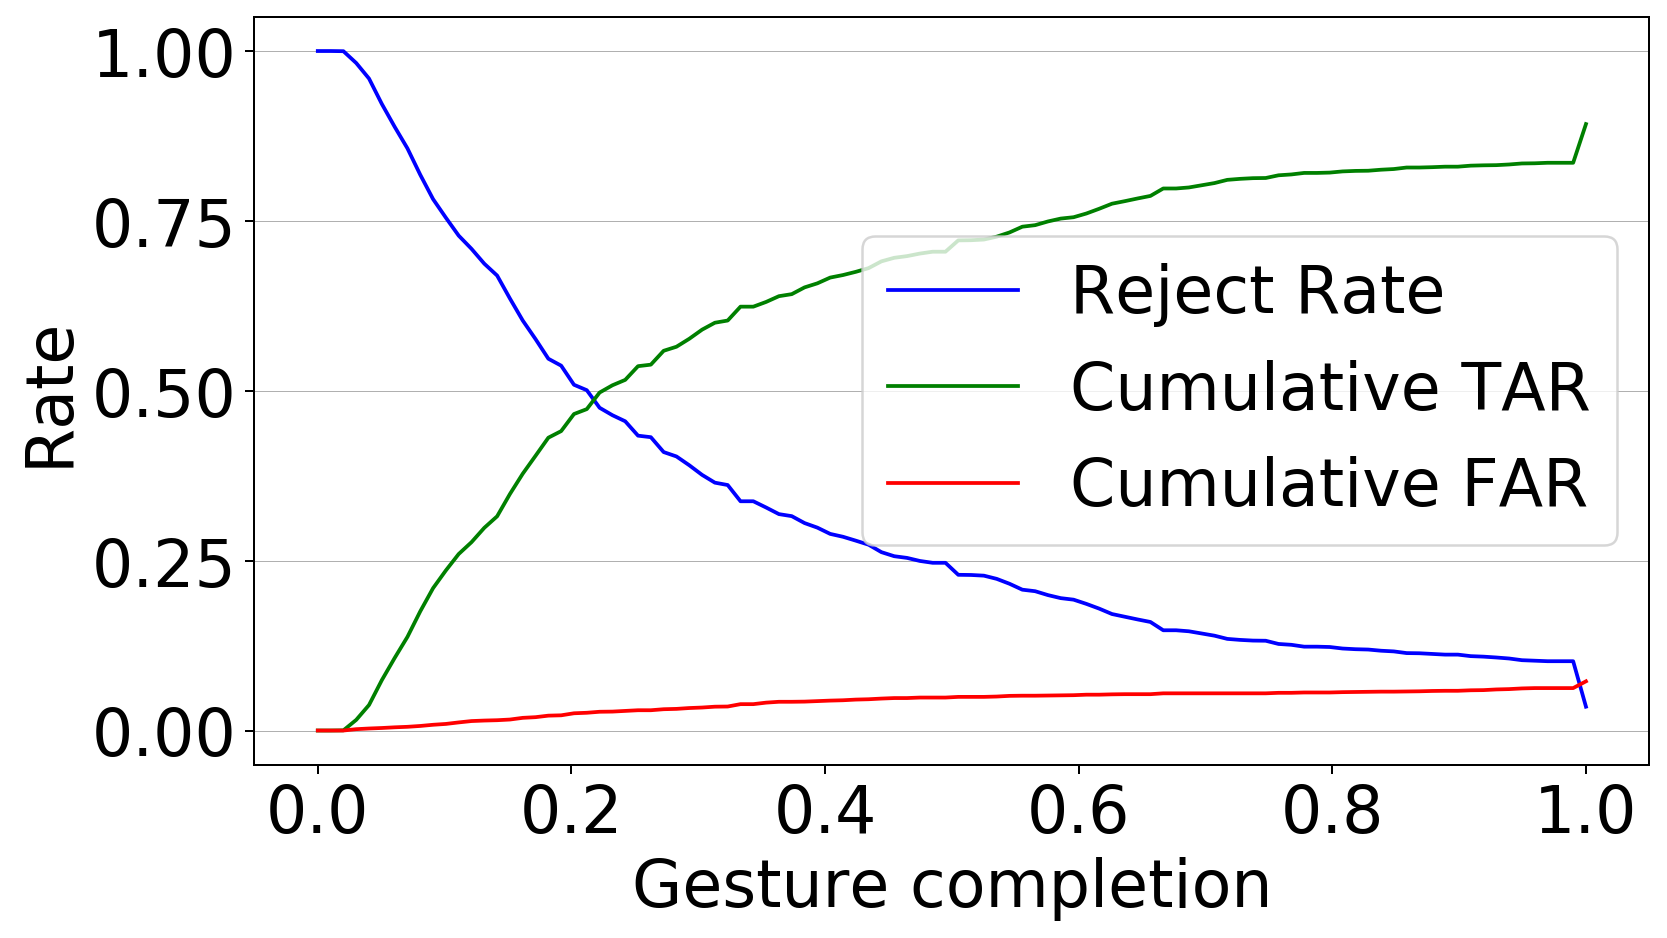

In [19]:
plt.rcParams.update({'font.size': 26})
plt.figure(figsize=(10,5.5),dpi=180)
xAbs = np.linspace(0,1,100)
flat_averageLengthCompletion = [item for sublist in averageLengthCompletion for item in sublist]

lengcomplt = np.array(flat_averageLengthCompletion)
# lengcomplt[]
rejectsAt = np.array(list(map(lambda x : 1-len(lengcomplt[lengcomplt<=x])/N_,xAbs)))
plt.plot(xAbs, rejectsAt,color="blue")


TrueAcceptAt = np.array(TrueAcceptAt)
FalseAcceptAt = np.array(FalseAcceptAt)
totalExemples = len(lengcomplt)

#cumulated TAR and FAR
TARAt = np.array(list(map(lambda x : len(TrueAcceptAt[TrueAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, TARAt,color="green")



FARAt = np.array(list(map(lambda x : len(FalseAcceptAt[FalseAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, FARAt,color="red")
plt.grid(axis="y",linestyle="-",linewidth=.4)

plt.legend(["Reject Rate","Cumulative TAR","Cumulative FAR"])
plt.xlabel("Gesture completion")
plt.ylabel("Rate")

# plt.plot(X, Yb)
# plt.plot(X, Yb)
plt.savefig(pathModelGeneral+"TAR_FAR_Reject"+("_t"+str(t) if t>1 else "")+".eps", bbox_inches='tight',format='eps')
plt.savefig(pathModelGeneral+"TAR_FAR_Reject"+("_t"+str(t) if t>1 else ""), bbox_inches='tight')


In [20]:
input.shape

TensorShape([1, 25, 40, 40, 2])